##### Бронников Максим Андреевич
##### М8О-407Б-17

<h1><center>Сети с радиальными базисными элементами </center></h1>

**Целью работы** является исследование свойств некоторых видов сетей с радиальными базисными элементами, алгоритмов обучения, а также применение сетей в задачах классификации и аппроксимации функции.

In [1]:
Сеть с радиально-базисными элементамиimport matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.svm import SVC

from neupy.algorithms import PNN, GRNN
None

/home/mbronnikov/miniconda3/envs/py36/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**Вариант №4:** 

Эллипс: $a = 0.4, b = 0.15, \alpha = \frac{\pi}{6}, x_0 = 0, y_0 = 0$

Эллипс: $a = 0.7, b = 0.5, \alpha = -\frac{\pi}{3}, x_0 = 0, y_0 = 0$

Эллипс: $a = 1, b = 1, \alpha = 0, x_0 = 0, y_0 = 0$


In [2]:
a1 = 0.4
b1 = 0.15
x0_1 = 0 # координаты параллельного переноса
y0_1 = 0
alpha1 = np.pi/6 # угол поворота

a2 = 0.7
b2 = 0.5
x0_2 = 0
y0_2 = 0
alpha2 = -np.pi/3

a3 = 1
b3 = 1
x0_3 = 0
y0_3 = 0
alpha3 = 0

t = np.linspace(0, 2 * np.pi, int(2 * np.pi / 0.025), endpoint=True)

In [3]:
def f(alpha, x0, a, t, y0, b):
    return (x0 + a * np.cos(t)) * np.cos(alpha) + (y0 + b * np.sin(t)) * np.sin(alpha)

def g(alpha, x0, a, t, y0, b):
    return -(x0 + a * np.cos(t)) * np.sin(alpha) + (y0 + b * np.sin(t)) * np.cos(alpha)

### Описание

**Сеть с радиально-базисными элементами**

<img src="https://basegroup.ru/sites/default/files/pic2.gif">

**Вероятностная нейронная сеть**

<img src="img/1.png">

**Обобщенно-регрессионная неройнная сеть**

<img src="https://www.researchgate.net/profile/Beyza-Ustaoglu/publication/229887649/figure/fig9/AS:668748956573696@1536453584177/The-structure-of-the-generalized-regression-neural-network-GRNN.png">

Все эти сети объединяет использование *радиально-базисных функций* в качестве функции активации для скрытых слоев нейронной сети.

Радиально-базисной функции называется любая вещественно-значная функция, значение которой монотонно убывает в зависимости от растояния. Наиболее популярный пример - *функция Гаусса:*

$$f(x) = e^{-\displaystyle\frac{\| x - c \|^2}{r}}$$

### Генерируем данные

Данные для 3-ех классов:

In [4]:
x1 = f(alpha1, x0_1, a1, t, y0_1, b1)
y1 = g(alpha1, x0_1, a1, t, y0_1, b1)

x2 = f(alpha2, x0_2, a2, t, y0_2, b2)
y2 = g(alpha2, x0_2, a2, t, y0_2, b2)

x3 = f(alpha3, x0_3, a3, t, y0_3, b3)
y3 = g(alpha3, x0_3, a3, t, y0_3, b3)

Иллюстрация классов:

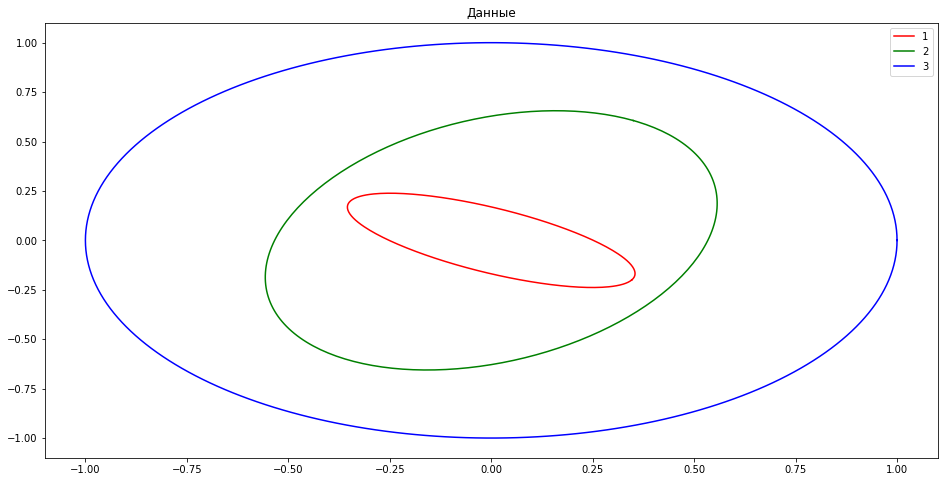

In [5]:
plt.figure(figsize=(16, 8))
plt.plot(x1, y1, 'r', label='1')
plt.plot(x2, y2, 'g', label='2')
plt.plot(x3, y3, 'b', label='3')
plt.title("Данные")
plt.legend()

Для трех линейно неразделимых классов решим задачу классификации

In [6]:
df1 = pd.DataFrame({'x' : x1, 'y' : y1, 'class' : 0})
df2 = pd.DataFrame({'x' : x2, 'y' : y2, 'class' : 1})
df3 = pd.DataFrame({'x' : x3, 'y' : y3, 'class' : 2})

Разделим выборку на тренировочную и тестовую  в соотношении 80% и 20% соответственно.

In [7]:
def make_split(data):
    xTrain, xTest = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)
    return xTrain, xTest

In [8]:
train, test = [], []

tmpTrain, tmpTest = make_split(df1)
train.append(tmpTrain)
test.append(tmpTest)

tmpTrain, tmpTest = make_split(df2)
train.append(tmpTrain)
test.append(tmpTest)

tmpTrain, tmpTest = make_split(df3)
train.append(tmpTrain)
test.append(tmpTest)

train = pd.concat(train)
test = pd.concat(test)

Зададим область точек [-1.2, 1.2] x [-1.2, 1.2]. Получим сетку для указанной области с шагом h = 0.025.

In [9]:
def classify_square3(model_func, a1=-1.2, b1=1.2, a2=-1.2, b2=1.2, step=0.025):
    X_paint = np.array([[a1, a2]]).reshape((1, 2))

    # init data
    for i in np.arange(a1, b1, step):
        for j in np.arange(a2, b2, step):
            X_paint = np.append(X_paint, np.array([[i, j]]), axis=0)

    Y_paint = model_func(X_paint)

    color1 = 'r'
    x1 = X_paint[(Y_paint == 0)]

    color2 = 'g'
    x2 = X_paint[(Y_paint == 1)]

    color3 = 'b'
    x3 = X_paint[(Y_paint == 2)]

    plt.figure(figsize=(12, 8))
    plt.scatter(x1.T[0], x1.T[1], marker='s', color=color1)
    plt.scatter(x2.T[0], x2.T[1], marker='s', color=color2)
    plt.scatter(x3.T[0], x3.T[1], marker='s', color=color3)

    plt.title("Классификация заданной области на 3 класса")

В этой функции мы производим обучение модели на тренировочных данных, предсказываем выход сети по тренировочным данным, получаем метрики обучения: accuracy, mse, rmse. То же самое проделываем и для тестового множества.

In [10]:
def train_predict(model, train, test):

    model.fit(train.iloc[:, 1:], train['class'])

    p = model.predict(train.iloc[:, 1:])
    accuracy_train = accuracy_score(train['class'], p)
    mse_train = mean_squared_error(train['class'], p)
    
    print('Train accuracy = {}'.format(accuracy_train))
    print('Train MSE = {}'.format(mse_train))
    print('Train RMSE = {}'.format(np.sqrt(mse_train)))
    
    plt.figure(figsize=(12, 8))
    mask = (p == 0)
    plt.scatter(train['x'][mask], train['y'][mask], color='r')
    mask = (p == 1)
    plt.scatter(train['x'][mask], train['y'][mask], color='g')
    mask = (p == 2)
    plt.scatter(train['x'][mask], train['y'][mask], color='b')
    plt.grid(True)
    plt.title('Train')
    plt.show()
    
    p = model.predict(test.iloc[:, 1:])
    accuracy_test = accuracy_score(test['class'], p)
    mse_test = mean_squared_error(test['class'], p)
    
    print('Test accuracy = {}'.format(accuracy_test))
    print('Test MSE = {}'.format(mse_test))
    print('Test RMSE = {}'.format(np.sqrt(mse_test)))
    
    plt.figure(figsize=(12, 8))
    mask = (p == 0)
    plt.scatter(test['x'][mask], test['y'][mask], color='r')
    mask = (p == 1)
    plt.scatter(test['x'][mask], test['y'][mask], color='g')
    mask = (p == 2)
    plt.scatter(test['x'][mask], test['y'][mask], color='b')
    plt.grid(True)
    plt.title('Test')
    plt.show()

### Задание №1

Для трех линейно неразделимых классов решить задачу классификации.

Построим вероятностную сеть, которая будет классифицировать точки заданной области.

$std = 0.3$

Train accuracy = 0.91
Train MSE = 0.09
Train RMSE = 0.3


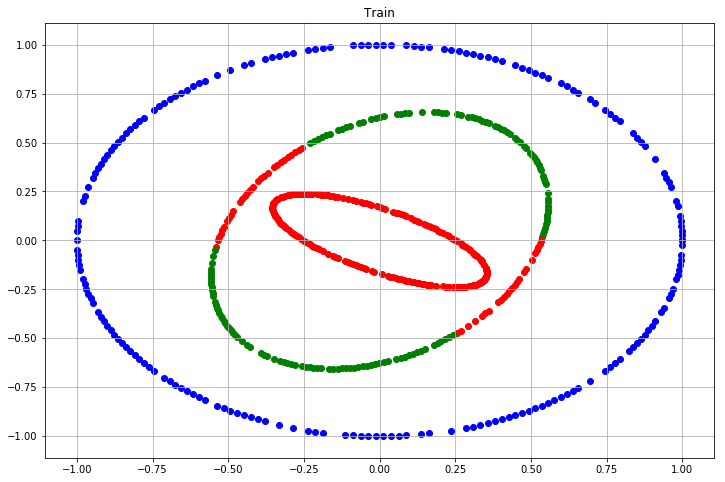

Test accuracy = 0.9019607843137255
Test MSE = 0.09803921568627451
Test RMSE = 0.3131121455425747


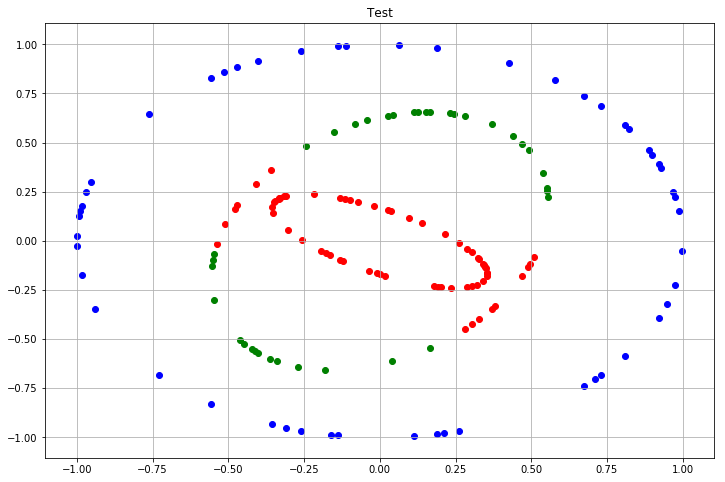

In [11]:
model = PNN(std=0.3)
train_predict(model, train, test)

Произведем классификацию точек области [-1.2, 1.2]x[-1.2, 1.2]. Закодируем принадлежности к классам различными цветами.

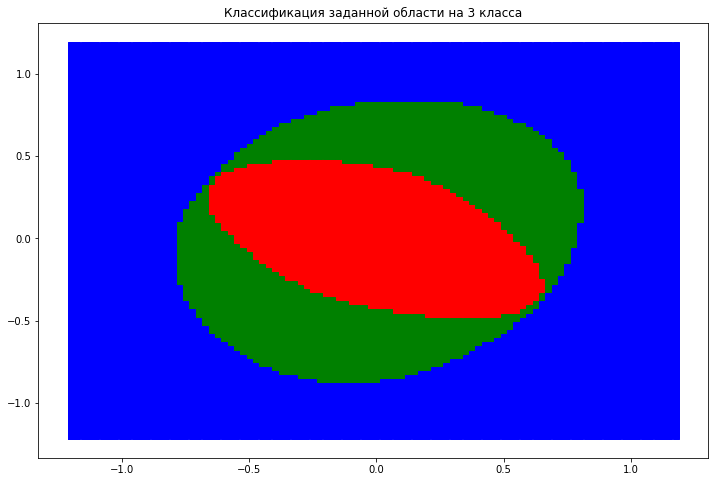

In [12]:
classify_square3(model.predict)

$std = 0.1$

Train accuracy = 1.0
Train MSE = 0.0
Train RMSE = 0.0


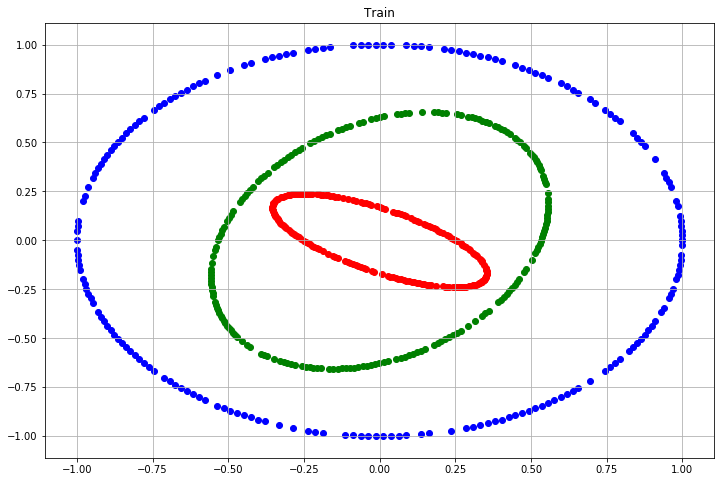

Test accuracy = 1.0
Test MSE = 0.0
Test RMSE = 0.0


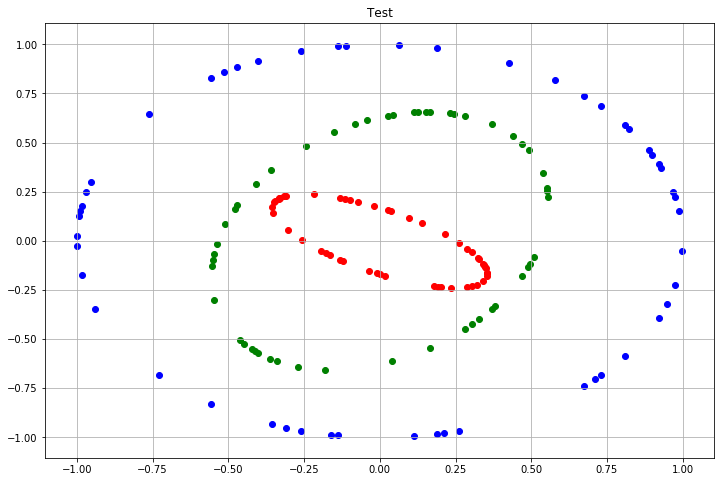

In [13]:
model = PNN(std=0.1)
train_predict(model, train, test)

Произведем классификацию точек области [-1.2, 1.2]x[-1.2, 1.2]. Закодируем принадлежности к классам различными цветами.

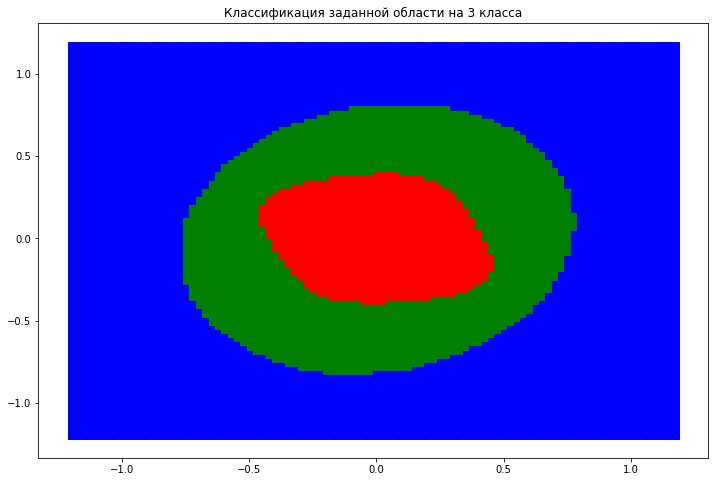

In [14]:
classify_square3(model.predict)

### Задание №2

Для трех линейно неразделимых классов решить задачу классификации.

Построим сеть с радиальными базисными элементами (rbf), которая будет классифицировать точки заданной области.

Созданные данные в предыдущем задании в отношении 80%-20% будут использоваться и в этом задании.

$std = 0.3$

Train accuracy = 1.0
Train MSE = 0.0
Train RMSE = 0.0


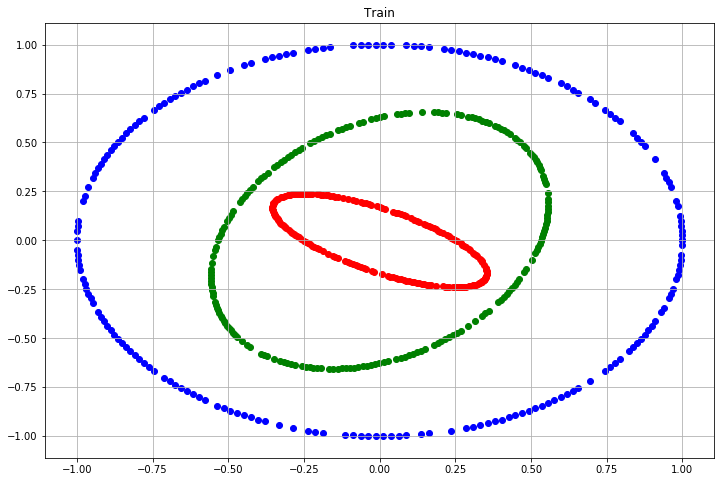

Test accuracy = 1.0
Test MSE = 0.0
Test RMSE = 0.0


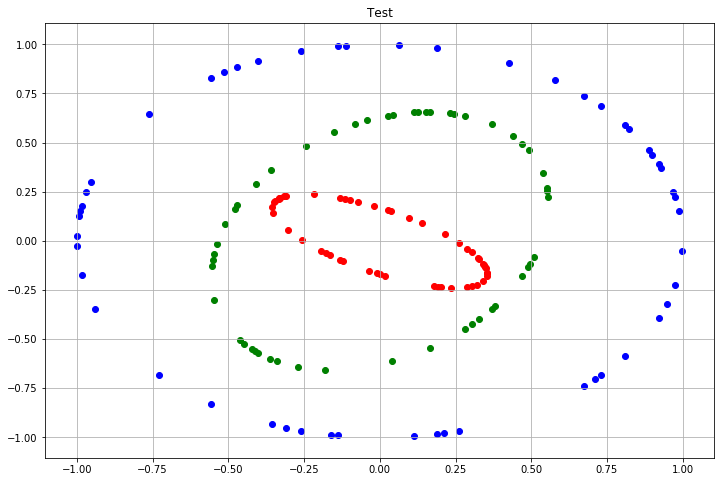

In [15]:
model = SVC(kernel='rbf', C=1e2, gamma=0.3)
train_predict(model, train, test)

Произведем классификацию точек области [-1.2, 1.2]x[-1.2, 1.2]. Закодируем принадлежности к классам различными цветами.

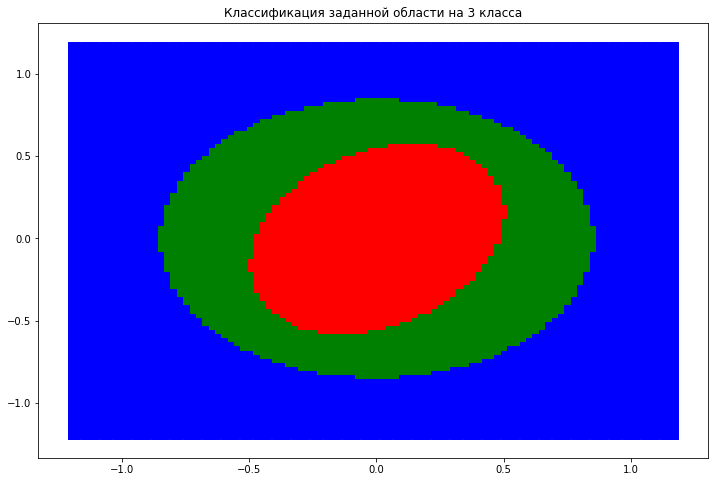

In [16]:
classify_square3(model.predict)

$std = 0.1$

Train accuracy = 1.0
Train MSE = 0.0
Train RMSE = 0.0


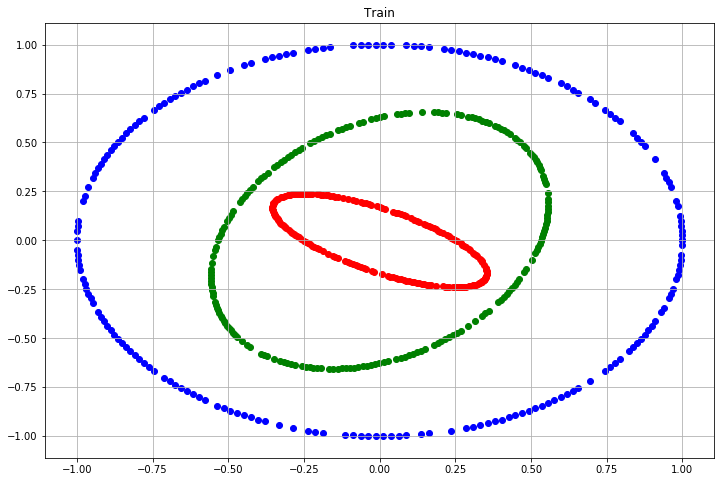

Test accuracy = 1.0
Test MSE = 0.0
Test RMSE = 0.0


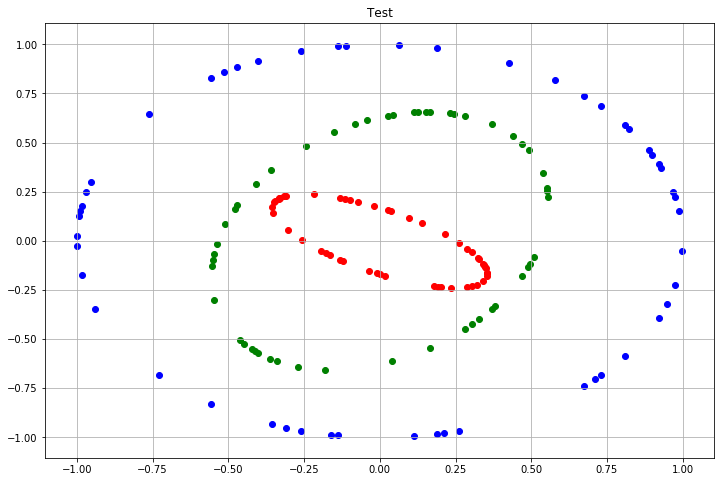

In [17]:
model = SVC(kernel='rbf', C=1e2, gamma=0.1)
train_predict(model, train, test)

Произведем классификацию точек области [-1.2, 1.2]x[-1.2, 1.2]. Закодируем принадлежности к классам различными цветами.

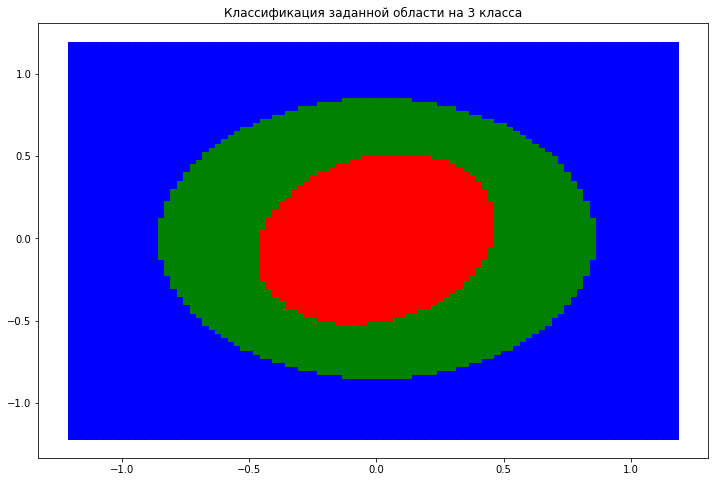

In [18]:
classify_square3(model.predict)

### Задание №3

Построить обобщенно-регрессионную нейронную сеть, которая будет выполнять аппроксимацию функции $x = cos(-3 * t^2 + 5*t + 10)$

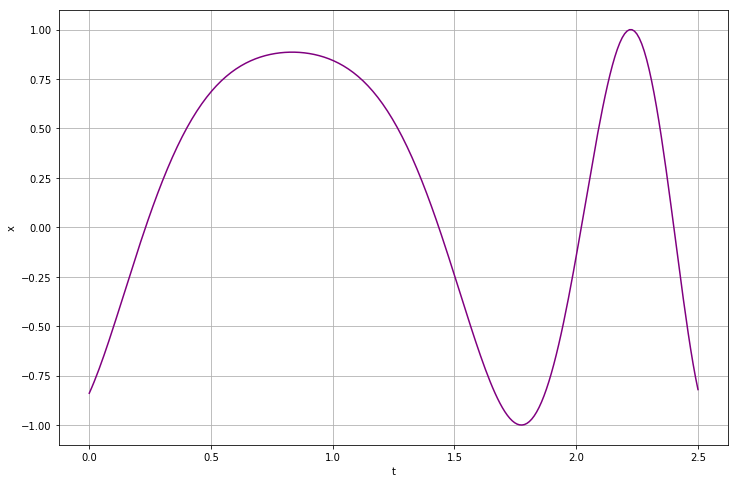

In [19]:
def f(t):
    return np.cos(-3*t**2 + 5*t + 10)

h = 0.01
t = np.linspace(0, 2.5, int(2.5 / h), endpoint=True)
x = f(t)

plt.figure(figsize=(12, 8))
plt.grid()
plt.xlabel('t')
plt.ylabel('x')
plt.plot(t, x, color='purple')
None

В этой функции мы нормализуем данные (тестовые и тренировочные). Затем обучим на тренировочных данных сеть, сделаем предсказания на тренировочных данных, оценим качество обучения с помощью метрик mse, rmse. Получим апостериорную оценку качества работы сети: то же самое проделаем для тестовых данных.

In [20]:
def scale_train_predict(model, train_x, train_y, test_x, test_y):
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    scaled_train_x = scaler_x.fit_transform(train_x[:, np.newaxis])
    scaled_test_x = scaler_x.transform(test_x[:, np.newaxis])
    scaled_train_y = scaler_y.fit_transform(train_y[:, np.newaxis])
    
    model.fit(scaled_train_x, scaled_train_y)
    
    predicted = model.predict(scaled_train_x)
    predicted = scaler_y.inverse_transform(predicted)

    mse = mean_squared_error(train_y, predicted.flatten())
    print('Ошибка обучения на тренировочном множестве')
    print('MSE =', mse)
    print('RMSE =', np.sqrt(mse))
    
    plt.figure(figsize=(12, 8))
    plt.grid()
    plt.xlabel('t')
    plt.ylabel('x')
    plt.scatter(train_x, train_y, label='Train', color='green')
    plt.scatter(train_x, predicted, label='Predicted', color='purple')
    plt.legend()
    plt.legend()
    plt.show()

    predicted = model.predict(scaled_test_x)
    predicted = scaler_y.inverse_transform(predicted)
    
    mse = mean_squared_error(test_y, predicted.flatten())
    print('Ошибка предсказания на тестовой выборке')
    print('MSE =', mse)
    print('RMSE =', np.sqrt(mse))
    
    plt.figure(figsize=(12, 8))
    plt.grid()
    plt.xlabel('t')
    plt.ylabel('x')
    plt.scatter(test_x, test_y, label='Test', color='green')
    plt.scatter(test_x, predicted, label='Predicted', color='purple')
    plt.legend()
    plt.show()

Делим на тестовую и тренировочную выборку. Выделяем с конца временной последовательности 10% на тестовое подмножество, соответственно на тренировочное множество кладем 90%.

In [21]:
size_train = int(len(t) * 0.9)

train_x = t[:size_train]
train_y = x[:size_train]
test_x = t[size_train:]
test_y = x[size_train:]

Ошибка обучения на тренировочном множестве
MSE = 0.000340887080849988
RMSE = 0.018463127602061032


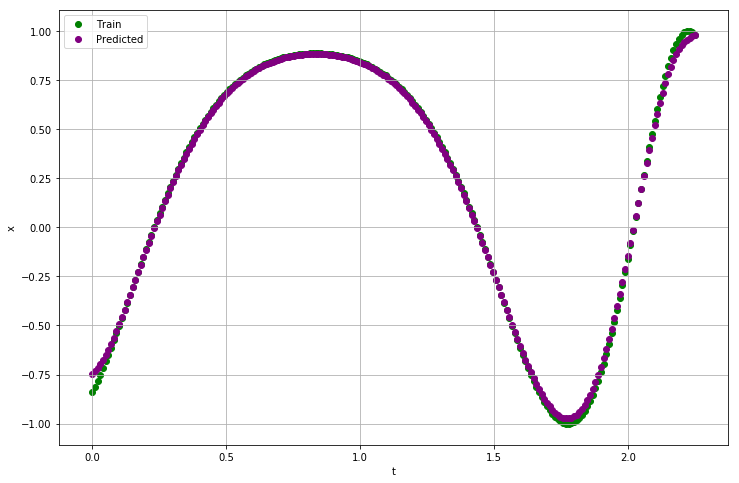

Ошибка предсказания на тестовой выборке
MSE = 1.03570899577641
RMSE = 1.0176978902289275


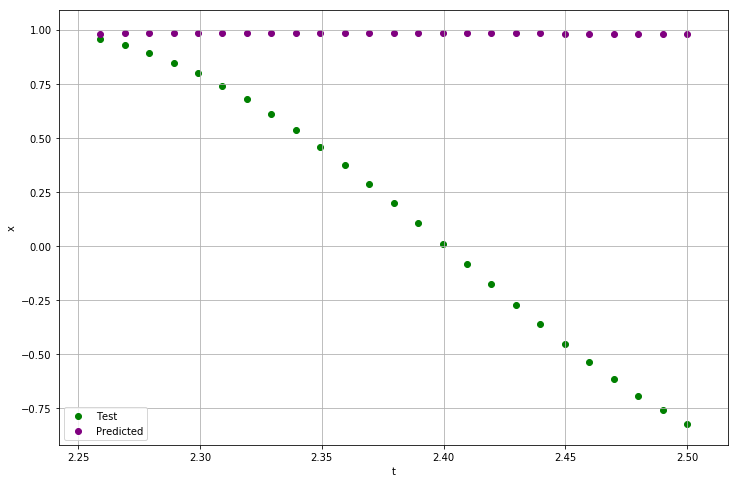

In [22]:
model = GRNN(std=0.09)
scale_train_predict(model, train_x, train_y, test_x, test_y)

Разделим тренировочную и тестовую выборку в соотношении 80% и 20% соответственно.

In [23]:
train_x, test_x, train_y, test_y = train_test_split(t, x, train_size=0.8, shuffle=True, random_state=4)

/home/mbronnikov/miniconda3/envs/py36/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Ошибка обучения на тренировочном множестве
MSE = 0.00013301573664298088
RMSE = 0.011533244844491116


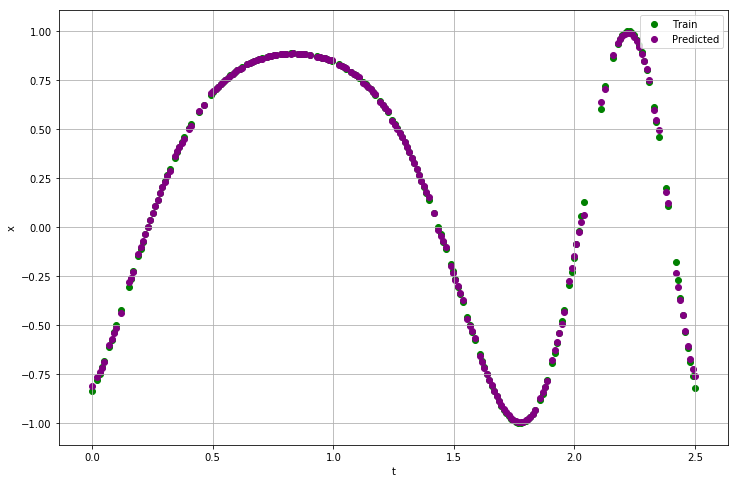

Ошибка предсказания на тестовой выборке
MSE = 0.0021008024633076524
RMSE = 0.04583451170578402


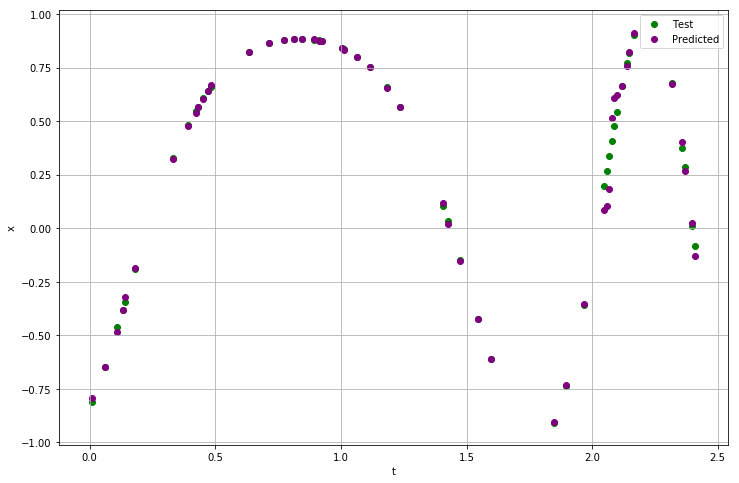

In [24]:
model = GRNN(std=0.03)
scale_train_predict(model, train_x, train_y, test_x, test_y)

<center><h5> Выполнил Бронников Максим </h5></center>
<center><h5> 16.01.2021 </h5></center>